In [1]:
using JuMP, Ipopt

In [2]:
my_optimizer = with_optimizer(Ipopt.Optimizer, print_level = 0)

MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawParameter("print_level") => 0])

In [3]:
begin
    const c1 = 1; # Spring constant
    const c2 = 1;
    const c3 = 1;
    const m1 = 5.0; # Mass
    const m2 = 5.0;
    const m3 = 5.0;
    const m4 = 5.0;
end

5.0

In [4]:
A = [0 0 0 0 1 0 0 0; 0 0 0 0 0 1 0 0 ; 0 0 0 0 0 0 1 0 ; 0 0 0 0 0 0 0 1 ; -c1/m1 c1/m1 0 0 0 0 0 0 ; c1/m2 -(c2+c1)/m2 c2/m2 0 0 0 0 0 ; 0 c2/m3 -(c2+c3)/m3 c3/m3 0 0 0 0 ; 0 0 c3/m4 -c3/m4 0 0 0 0]


8×8 Matrix{Float64}:
  0.0   0.0   0.0   0.0  1.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0  0.0  1.0  0.0  0.0
  0.0   0.0   0.0   0.0  0.0  0.0  1.0  0.0
  0.0   0.0   0.0   0.0  0.0  0.0  0.0  1.0
 -0.2   0.2   0.0   0.0  0.0  0.0  0.0  0.0
  0.2  -0.4   0.2   0.0  0.0  0.0  0.0  0.0
  0.0   0.2  -0.4   0.2  0.0  0.0  0.0  0.0
  0.0   0.0   0.2  -0.2  0.0  0.0  0.0  0.0

In [5]:
B = [0 0 0 0 ; 0 0 0 0 ; 0 0 0 0; 0 0 0 0; 1/m1 0 0 0 ; 0 1/m2 0 0; 0 0 1/m3 0 ; 0 0 0 1/m4] # Input matrix

8×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.2  0.0  0.0  0.0
 0.0  0.2  0.0  0.0
 0.0  0.0  0.2  0.0
 0.0  0.0  0.0  0.2

In [6]:
C = [1 0 0 0 0 0 0 0 ; 0 1 0 0 0 0 0 0 ; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0 ; ] # Output matrix

4×8 Matrix{Int64}:
 1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0
 0  0  1  0  0  0  0  0
 0  0  0  1  0  0  0  0

In [7]:
Nx = size(A)[1]


8

In [8]:
Nu = size(B)[2]

4

In [9]:
mech_osc(x,u) = A * x + B * u   # System dynamics

mech_osc (generic function with 1 method)

In [10]:
function mpc_emo(x_init)

    model = Model(my_optimizer)
    
    ΔT = 0.1            #  Sampling time
    n_horizon = 20;     # MPC horizon

    Nx = size(A)[1]
    Nu = size(B)[2]

    # Input constraints
    umin = -100.0
    umax = 100.0 

    ref = [2.0, 4.0, 0.0, 0.0,  0.0, 0.0, 0.0, 0.0] # Reference 
    #ref = zeros(8) # Reference 
    @variables model begin
        x[1:Nx, 1:n_horizon]    # States
        e[1:Nx, 1:n_horizon]    # Errors = Reference - States
        umin <= u[1:Nu, 1:n_horizon] <= umax  # Input constraints
    end


    @constraint(model, x[1:Nx, 1] .== x_init )                          # Initial values
    @constraint(model, [k=1:n_horizon], e[:, k] .== ref[:] - x[:, k])   # Error = Reference - States
    @constraint(model, [k=1:n_horizon-1], x[:, k+1] .== x[:, k] + ΔT * mech_osc(x[:,k], u[:,k])) # System dynamics

    J = @NLexpression(model, 100*sum(e[i,end]^2 for i in 1:Nx) + sum(u[j,end]^2 for j in 1:Nu) )
    
    @NLobjective( model, Min, J)

    optimize!(model)
    return JuMP.value.(x), JuMP.value.(u), JuMP.value.(e)
end

mpc_emo (generic function with 1 method)

In [11]:
x_hist = zeros(8,0)
u_hist = zeros(4,0)
print(x_hist)

Matrix{Float64}(undef, 8, 0)

In [12]:
xpos = rand(8)

8-element Vector{Float64}:
 0.6029217500949646
 0.4840000918558207
 0.3322176816301159
 0.6777903665039826
 0.5859951578397833
 0.6653743385258504
 0.1220211699431013
 0.3615194168183733

In [13]:
for i in 1:50
    
    # Run the MPC control optimization
    x_plan, u_plan, e_plan = mpc_emo(xpos)
    
    # Save states
    x_hist = hcat(x_hist, x_plan[:,1])
    u_hist = hcat(u_hist, u_plan[:,1])

    # Apply the planned input signals and simulate one step in time
    ΔT = 0.1
    xpos = xpos + ΔT * mech_osc(xpos, u_plan[:,1])
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



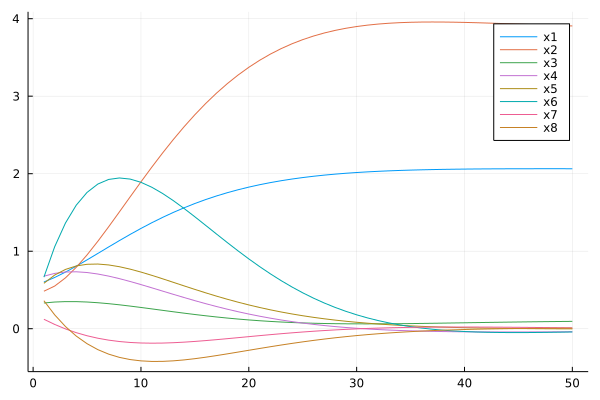

In [14]:
using Plots
plot(x_hist', labels=["x1" "x2" "x3" "x4" "x5" "x6" "x7" "x8"])

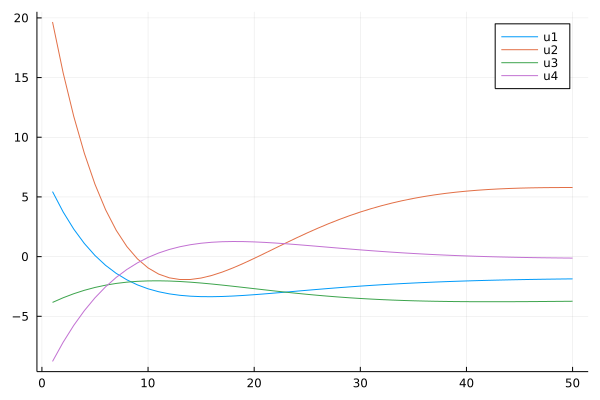

In [15]:
using Plots
plot(u_hist', labels=["u1" "u2" "u3" "u4"])

In [16]:
savefig("umpc")